In [1]:
library(tidyverse)
library(tidytext)
library(textstem)
options(repr.plot.res=1000)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
“il pacchetto ‘tidytext’ è stato creato con R versione 4.3.3”
Warning message:
“il pacchetto ‘textstem’ è stato creato con R versione 4.3.3”
Caricamento del pacchetto richiesto: koRpus.lang.en

Caricamento del pacchetto richiesto: koRpus

Caricamento del pacchetto richiesto: sylly

For information on available language packages for 'koRpus', run

  available.koRpus.lang()

and see ?install.koRpus.lang()



Caricamento pacchetto: ‘koRpus’


Il seguente ogg

# Multinomial Naive Bayes algorithm

In [2]:
garbage <- stop_words |> filter(lexicon=='snowball')
head(garbage)

word,lexicon
<chr>,<chr>
i,snowball
me,snowball
my,snowball
myself,snowball
we,snowball
our,snowball


In [3]:
tokenise <- function(df, stopwords=garbage){
    df |> mutate(
        word=Text |>
        str_to_lower() |>
        str_remove_all(r"(can't|n't|'s|'ve|'d|'ll|'re|'m|[[:punct:][:symbol:]])") |>
        str_extract_all(r"([:alpha:]{2,})")
    ) |> unnest(word) |>
    anti_join(stopwords, "word") |>
    mutate(word=lemmatize_words(word))
}



trainMNB <- function(training_data, k=0){
    N <- nrow(training_data)  # num docs
    training_data <- training_data |> add_count(Labels, name="n.labels")  # num docs by class
    
    tokens <- tokenise(training_data)

    # feature selection
    if (k != 0) {
        # vocabulary
        Nk <- N + 4
        V <- tokens |> distinct() |> add_count(word, name="n.words")  |>  # num docs with word
            add_count(Labels, word, name="n11") |>  # docs with t in c
            distinct(word, Labels, .keep_all=T) |>  # drop duplicates not to hinder slice_max
            mutate(n11=n11 + 1,
                   n10=n.words - n11 + 1,  # docs with t not in c
                   n01=n.labels - n11 + 1,  # docs w/o t in c
                   n1.=n11 + n10, n.1=n11 + n01,
                   n00=Nk - n1. - n01 + 1,  # docs w/o t not in c
                   n0.=n00 + n01, n.0=n00 + n10,
                   mi=(n11*log2(Nk*n11/n1./n.1) + n01*log2(Nk*n01/n0./n.1) + n10*log2(Nk*n10/n1./n.0) + n00*log2(Nk*n00/n0./n.0)) / Nk  # mutual information
                  ) |> slice_max(mi, by=Labels, n=k) |> distinct(word)
        
        tokens <- tokens |> semi_join(V, "word")
    } else {V <- tokens |> distinct(word)}


    toklass <- tokens |> count(Labels, name="n.words.class")
    log.condprob <- tokens |> count(Labels, word, name="n.single.word.class") |> complete(Labels, word, fill=list(n.single.word.class=0)) |> inner_join(toklass, "Labels") |>
        mutate(prob=log((n.single.word.class + 1) / (n.words.class + nrow(V))), .keep="unused")

    log.prior <- training_data |> distinct(Labels, n.labels) |> mutate(prior=log(n.labels / N), .keep="unused")
    return (list(V, log.prior, log.condprob))  # Also returns the vocabulary following the pseudocode of reference, but unused
}



applyMNB <- function(data, log.prior, log.condprob, labels=F){
    predict <- tokenise(data) |>
        left_join(log.condprob, "word", relationship="many-to-many") |> summarise(prob=sum(prob), .by=c(Text, Labels.y)) |>  # join condprob (sum of prob of each word for each label)
        left_join(log.prior, join_by(Labels.y==Labels)) |> mutate(post=prob + prior) |>  # join prior and sum to condprob
        slice_max(post, by="Text") |>
        replace_na(list(Labels.y=( (log.prior |> slice_max(prior))$Labels )))  # if the Text doesn't contain any usable word the most occuring class is selected

    if(labels){predict <- predict |> inner_join(data, "Text")}
    return (predict)
}



train.n.apply <- function(training, testing, k=0, labels=T){
    MNB <- training |> trainMNB(k=k)
    testing |> applyMNB(MNB[[2]], MNB[[3]], labels=labels)
}



feature.search <- function(training, validation, k){
    mat <- matrix(, nrow=length(k), ncol=3)
    for (i in seq_along(k)){cat(k[i], '')
        flush.console()  # display cat on single row
        pred <- train.n.apply(training, validation, k=k[i])
        mat[i,] <- c(k[i], (pred |> filter(Labels==Labels.y) |> nrow()) / nrow(validation), pred |> filter(is.na(post)) |> nrow())  # k, overall accuracy, docs with no features
        }
    return(mat)
}

# [Multilabel Data](https://www.kaggle.com/datasets/anmolkumar/fake-news-content-detection)
- True - 5
- Not-Known - 4
- Mostly-True - 3
- Half-True - 2
- False - 1
- Barely-True - 0

## Preprocessing

In [2]:
data <- read_csv('data/og/train.csv') |> select(Labels, Text)
str(data)

Rows: 10240 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Text, Text_Tag
dbl (1): Labels

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


tibble [10,240 × 2] (S3: tbl_df/tbl/data.frame)
 $ Labels: num [1:10240] 1 2 3 1 2 5 0 2 2 3 ...
 $ Text  : chr [1:10240] "Says the Annies List political group supports third-trimester abortions on demand." "When did the decline of coal start? It started when natural gas took off that started to begin in (President Ge"| __truncated__ "Hillary Clinton agrees with John McCain \"by voting to give George Bush the benefit of the doubt on Iran.\"" "Health care reform legislation is likely to mandate free sex change surgeries." ...


Check missing values

In [8]:
sum(is.na(data))

[1] 0

We remove all the data labelled as "Not known" (some examples are shown in the cell below), and take care of duplicate rows.

In [9]:
data |> filter(Labels==4) |> slice_sample(n=5)

Labels,Text
<dbl>,<chr>
4,2014 Federal Tax Refunds To Be Delayed Until October 2015.
4,Wendy Davis raised money for a U.S. House Democrat who is a member of a Democratic socialists group.
4,Says Ted Cruz just flip-flopped about the president needing to be U.S.-born.
4,Final election 2016 numbers: Trump won the popular vote.
4,Says Barack Obama sold Chrysler to Italians who are going to build Jeeps in China at the cost of American jobs.


In [10]:
data <- data |> filter(Labels != 4) |> distinct()
str(data)

tibble [9,390 × 2] (S3: tbl_df/tbl/data.frame)
 $ Labels: num [1:9390] 1 2 3 1 2 5 0 2 2 3 ...
 $ Text  : chr [1:9390] "Says the Annies List political group supports third-trimester abortions on demand." "When did the decline of coal start? It started when natural gas took off that started to begin in (President Ge"| __truncated__ "Hillary Clinton agrees with John McCain \"by voting to give George Bush the benefit of the doubt on Iran.\"" "Health care reform legislation is likely to mandate free sex change surgeries." ...


Some entries come with different labels. Since we have no means to choose the correct one, we simply drop all instances.

In [11]:
dobble <- data[duplicated(data$Text),] |> select(Text)
data |> semi_join(dobble, "Text") |> arrange(Text)
data <- data |> anti_join(dobble, "Text")
str(data)

Labels,Text
<dbl>,<chr>
2,"Four balanced budgets in a row, with no new taxes for anyone. The best job growth in 12 years. Nearly 130,000 new private-sector jobs. Merit pay to reward New Jerseys best teachers, and the most education funding ever."
3,"Four balanced budgets in a row, with no new taxes for anyone. The best job growth in 12 years. Nearly 130,000 new private-sector jobs. Merit pay to reward New Jerseys best teachers, and the most education funding ever."
1,On abortion
2,On abortion
5,On support for gay marriage.
1,On support for gay marriage.
1,On the status of illegal immigrants
2,On the status of illegal immigrants
5,On torture.


tibble [9,378 × 2] (S3: tbl_df/tbl/data.frame)
 $ Labels: num [1:9378] 1 2 3 1 2 5 0 2 2 3 ...
 $ Text  : chr [1:9378] "Says the Annies List political group supports third-trimester abortions on demand." "When did the decline of coal start? It started when natural gas took off that started to begin in (President Ge"| __truncated__ "Hillary Clinton agrees with John McCain \"by voting to give George Bush the benefit of the doubt on Iran.\"" "Health care reform legislation is likely to mandate free sex change surgeries." ...


In [12]:
data |> count(Labels)

Labels,n
<dbl>,<int>
0,1653
1,1985
2,2107
3,1961
5,1672


Separate the sets, and save them to new files (the cell is in `Raw` mode to avoid accidentally running it)

## Training

In [5]:
training <- read_csv('data/training.csv')
validation <- read_csv('data/validation.csv')
test <- read_csv("data/test.csv")

Rows: 7175 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Text
dbl (1): Labels

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1266 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Text
dbl (1): Labels

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 937 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Text
dbl (1): Labels

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [68]:
training |> tokenise() |> distinct(Labels, word) |> count(Labels)

Labels,n
<dbl>,<int>
0,3336
1,3552
2,3623
3,3399
5,3206


In [69]:
k <- c(1:10, seq.int(15, 50, by=5), seq.int(100, 500, by=50), seq.int(600, 1000, by=100), seq.int(1500, 3000, by=500))
mat <- feature.search(training, validation, k)
mat[order(desc(mat[,2])),]

1 2 3 4 5 6 7 8 9 10 15 20 25 30 35 40 45 50 100 150 200 250 300 350 400 450 500 600 700 800 900 1000 1500 2000 2500 3000 

3000,0.2511848,0
250,0.2480253,34
1000,0.2464455,3
200,0.2456556,43
300,0.2440758,21
900,0.2432859,3
1500,0.2424961,1
800,0.2417062,4
2000,0.2409163,1
2500,0.2401264,1
2,0.2385466,756


In [70]:
# Validation for k=0
(train.n.apply(training, validation) |> filter(Labels==Labels.y) |> nrow()) / nrow(validation)

[1] 0.2511848

## Testing and results

In [71]:
result <- train.n.apply(training, test)

In [72]:
(result |> filter(Labels==Labels.y) |> nrow()) / nrow(test)

[1] 0.2411953

In [73]:
# Confusion Matrix (rows are true labels)
result |> count(Labels, Labels.y) |> pivot_wider(names_from=Labels.y, values_from=n) |> column_to_rownames("Labels") 

,0,1,2,3,5
,<int>,<int>,<int>,<int>,<int>
0,30,34,58,30,14
1,30,41,53,44,16
2,30,36,78,43,18
3,21,37,72,53,37
5,9,38,47,44,24


- True - 5
- Mostly-True - 3
- Half-True - 2
- False - 1
- Barely-True - 0

### Plot

In [74]:
k0 <- (train.n.apply(training, validation) |> filter(Labels==Labels.y) |> nrow()) / nrow(validation)

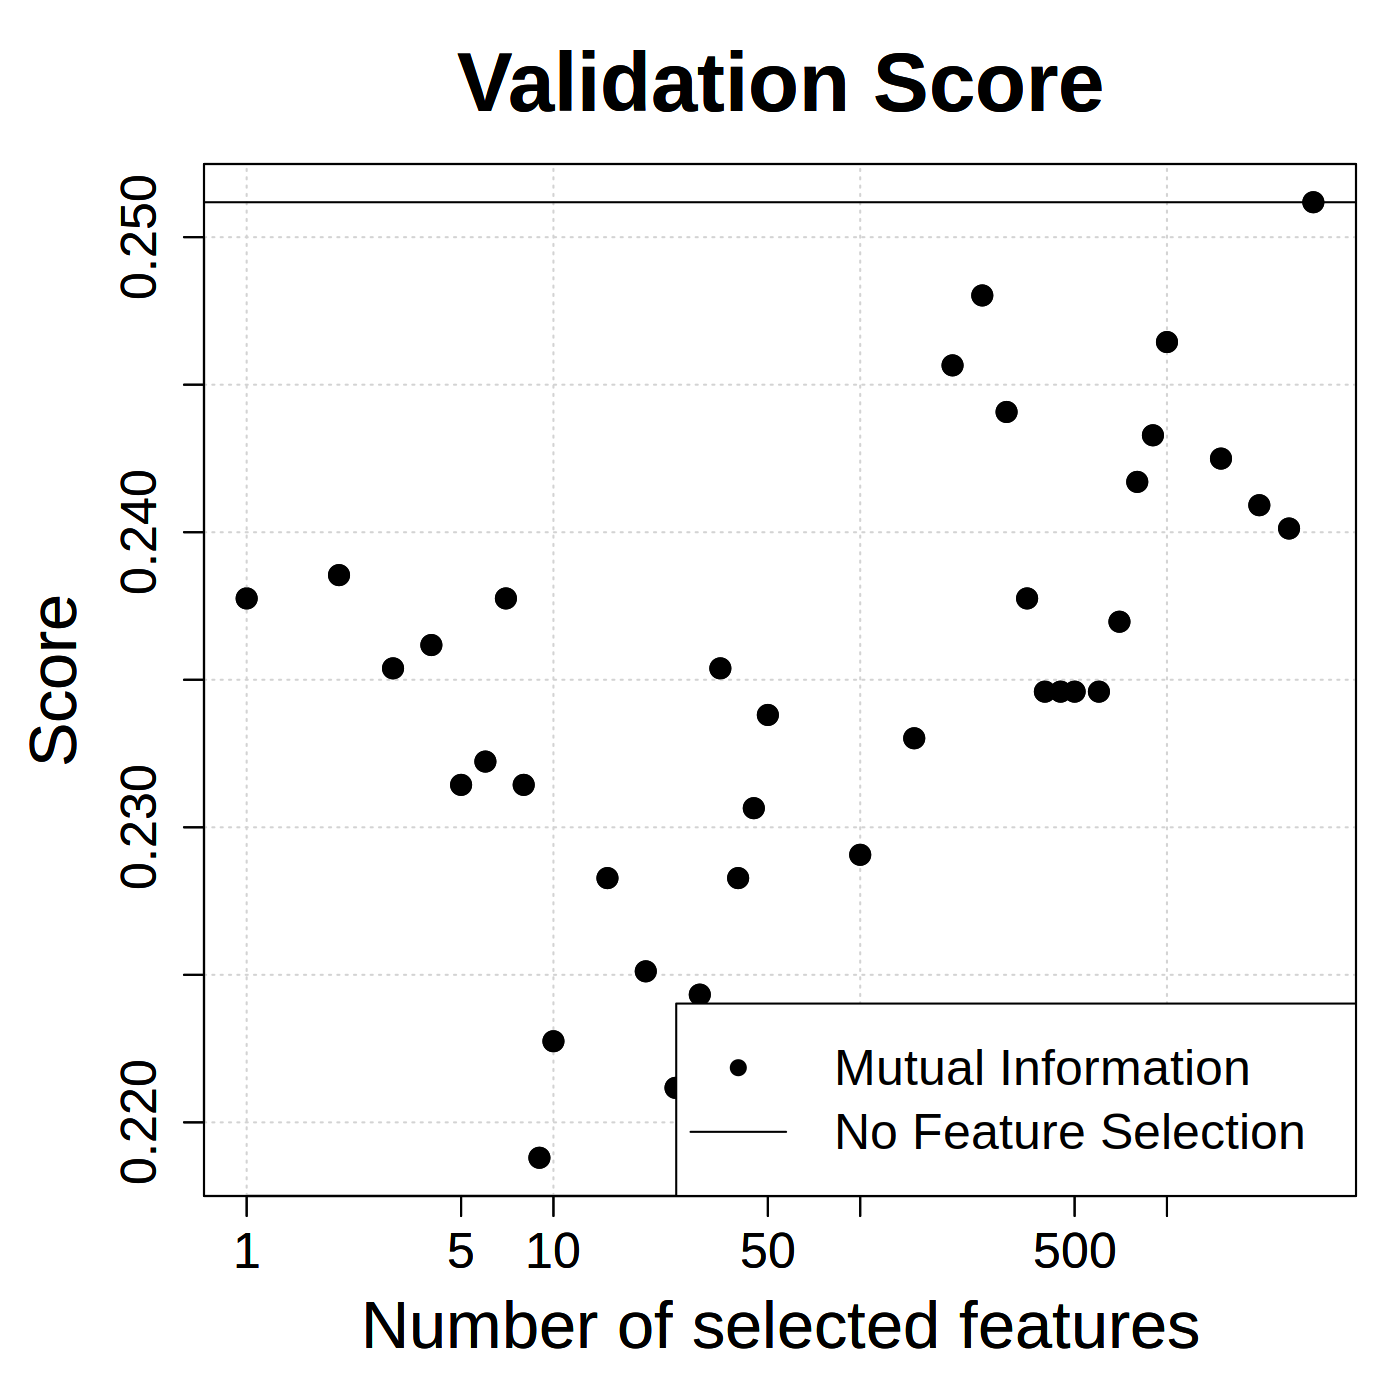

In [77]:
# png(file="multiclass_validation.png", width=800, height=800, pointsize=20)
# options(repr.plot.res=1000)  # for presentation
options(repr.plot.res=200)
par(mar=c(5,5,4,1)+.1)
plot(mat[,1], mat[,2], main="Validation Score", xlab="Number of selected features", ylab="Score", log="x", pch=20, cex.main=2.5, cex.lab=2, cex.axis=1.5, cex=2)
grid()
par(new=T, mar=c(5,5,4,1)+.1)
plot(mat[,1], mat[,2], main="Validation Score", xlab="Number of selected features", ylab="Score", log="x", pch=20, cex.main=2.5, cex.lab=2, cex.axis=1.5, cex=2)
abline(h=k0)
legend("bottomright", c("Mutual Information", "No Feature Selection"), lty=c(NA, 1), pch=c(20, NA), cex=1.5)
# dev.off()

---

# [Binary Dataset](https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification)
- 0 - True
- 1 - Fake

## Preprocessing

In [5]:
data <- read.csv('data2/WELFake_Dataset.csv') |> select(Text=text, Labels=label)

In [57]:
sum(is.na(data))

[1] 0

In [12]:
data |> count(Labels)

Labels,n
<int>,<int>
0,35028
1,37106


In [27]:
data |> nrow()
data |> distinct() |> nrow()

[1] 72134

[1] 62720

In [58]:
data <- data |> distinct()  # drop row duplicates (equal labels & Text)
nrow(data)

[1] 62720

In [59]:
data |> count(Labels)

Labels,n
<int>,<int>
0,34621
1,28099


In [29]:
data[duplicated(data$Text),]$Text

[1] " "

## Training

In [84]:
training <- read_csv('data2/training.csv')
validation <- read_csv('data2/validation.csv')
test <- read_csv('data2/test.csv')

Rows: 47981 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Text
dbl (1): Labels

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 8467 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Text
dbl (1): Labels

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 6272 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Text
dbl (1): Labels

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [41]:
training |> tokenise() |> distinct(Labels, word) |> count(Labels)

Labels,n
<dbl>,<int>
0,109728
1,223206


In [59]:
k <- c(seq.int(5, 50, by=5), seq.int(100, 500, by=50), seq.int(600, 1000, by=100), seq.int(1500, 10e3L, by=500), seq.int(20e3L, 1e5L, by=10e3L))
mat2 <- feature.search(training, validation, k)
mat2[order(desc(mat2[,2])),]

5 10 15 20 25 30 35 40 45 50 100 150 200 250 300 350 400 450 500 600 700 800 900 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 9500 10000 20000 30000 40000 50000 60000 70000 80000 90000 1e+05 

50000,0.9007913,2
60000,0.9007913,2
70000,0.9007913,2
80000,0.9007913,2
90000,0.9007913,2
100000,0.9007913,2
40000,0.8933507,8
30000,0.8932325,10
20000,0.8931144,10
10000,0.8927601,13
9500,0.8925239,13


In [39]:
feature.search(training, validation, 0)

0 

0,0.9007913,2


- Fake <- 0
- True <- 1

## Results

In [39]:
result <- train.n.apply(training, test, k=0)
(result |> filter(Labels==Labels.y) |> nrow()) / nrow(test)

[1] 0.9025829

In [40]:
# Confusion Matrix (rows are true labels)
result |> count(Labels, Labels.y) |> pivot_wider(names_from=Labels.y, values_from=n) |> column_to_rownames("Labels") 

,0,1
,<int>,<int>
0,3312,181
1,430,2349


### Plot

In [85]:
k0 <- (train.n.apply(training, validation, k=0) |> filter(Labels==Labels.y) |> nrow()) / nrow(validation)
k0

[1] 0.9007913

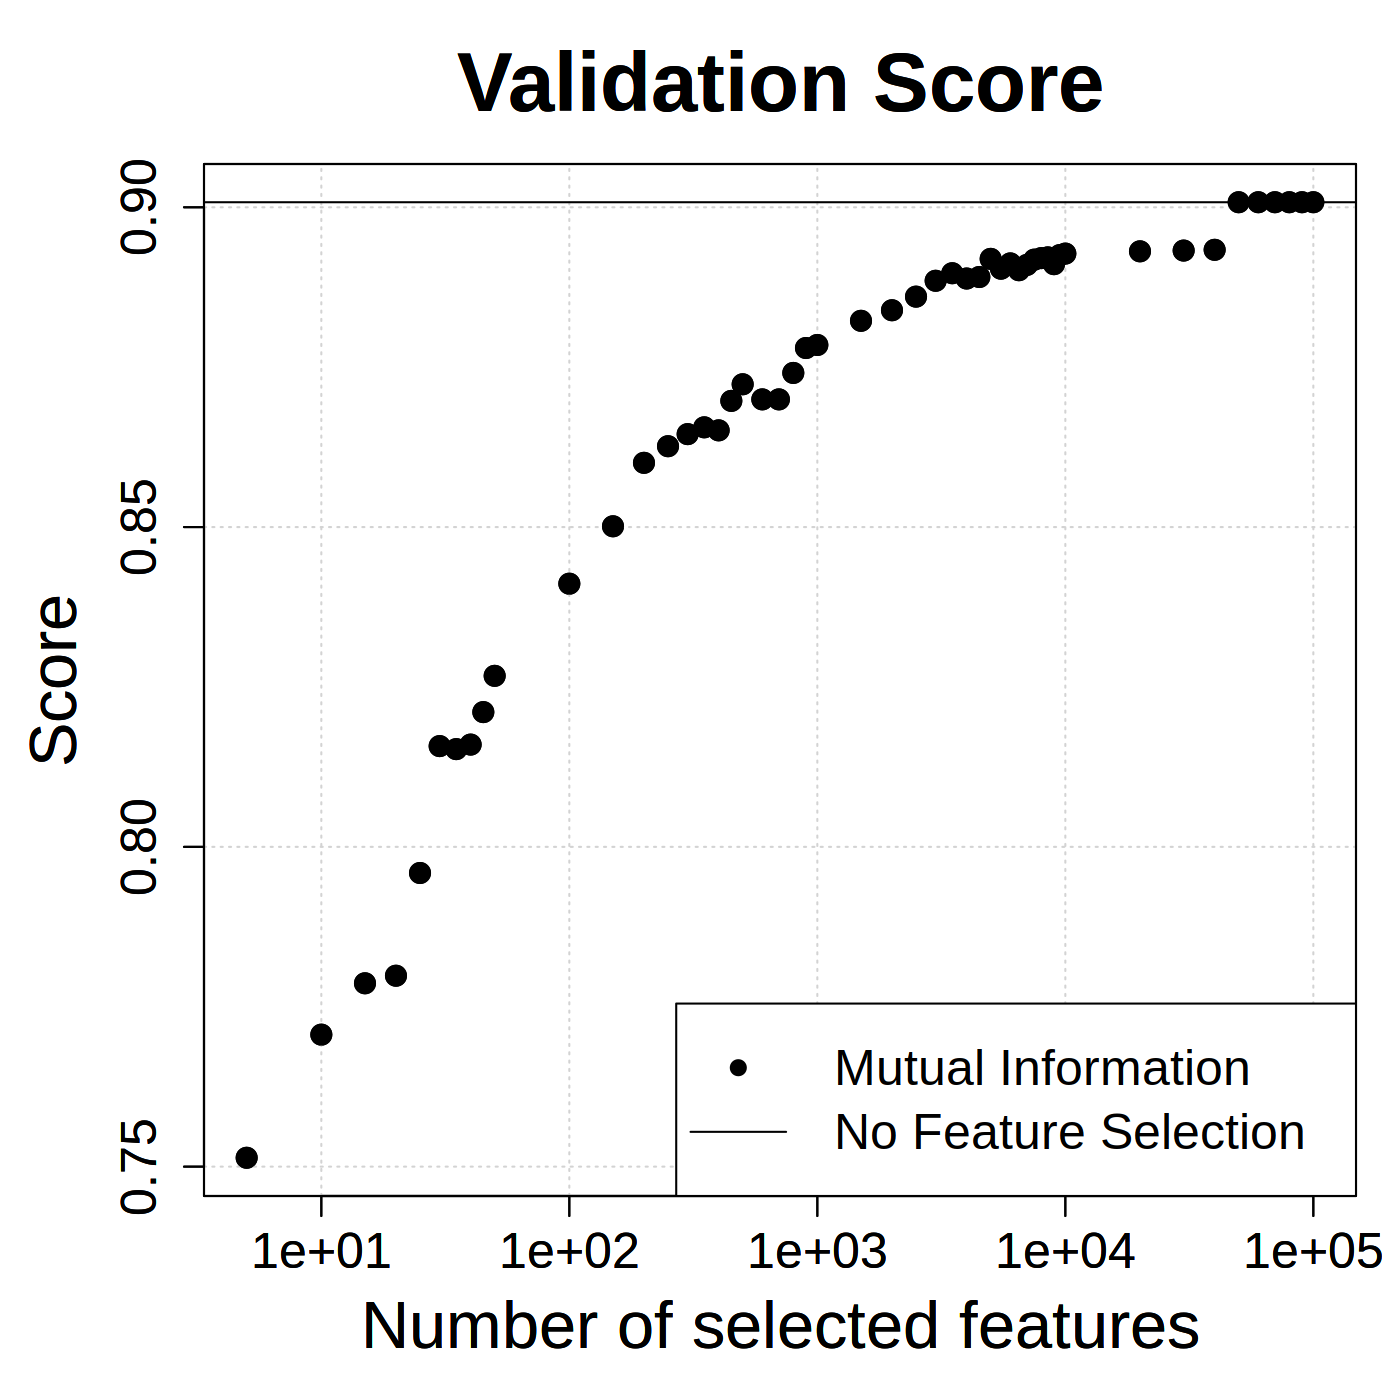

In [88]:
# png(file="binary_validation.png", width=800, height=800, pointsize=20)
# options(repr.plot.res=1000)
options(repr.plot.res=200)
par(mar=c(5,5,4,1)+.1)
plot(mat2[,1], mat2[,2], main="Validation Score", xlab="Number of selected features", ylab="Score", log="x", pch=20, cex.main=2.5, cex.lab=2, cex.axis=1.5, cex=2)
grid()
par(new=T, mar=c(5,5,4,1)+.1)
plot(mat2[,1], mat2[,2], main="Validation Score", xlab="Number of selected features", ylab="Score", log="x", pch=20, cex.main=2.5, cex.lab=2, cex.axis=1.5, cex=2)
abline(h=k0)
legend("bottomright", c("Mutual Information", "No Feature Selection"), lty=c(NA, 1), pch=c(20, NA), cex=1.5)
# dev.off()

---

# Appendix

## Binary Data 1

In [6]:
training |> filter(Labels %in% c(1,5)) |> count(Labels)

Labels,n
<dbl>,<int>
1,1524
5,1300


In [7]:
pred <- train.n.apply((training |> filter(Labels %in% c(1,5))), (validation |> filter(Labels %in% c(1,5))), k=0)
(pred |> filter(Labels==Labels.y) |> nrow()) / nrow(validation |> filter(Labels %in% c(1,5)))

[1] 0.6057495

In [15]:
test |> filter(Labels %in% c(1,5)) |> count(Labels) 

Labels,n
<dbl>,<int>
1,184
5,162


In [8]:
k <- c(1:10, seq.int(15, 50, by=5), seq.int(100, 500, by=50), seq.int(600, 1000, by=100), seq.int(1500, 3000, by=500))
matbin <- feature.search(training |> filter(Labels %in% c(1,5)), validation |> filter(Labels %in% c(1,5)), k=k)
matbin[order(desc(matbin[,2])),]

1 2 3 4 5 6 7 8 9 10 15 20 25 30 35 40 45 50 100 150 200 250 300 350 400 450 500 600 700 800 900 1000 1500 2000 2500 3000 

50,0.6324435,127
25,0.6303901,230
20,0.6262834,261
45,0.6262834,138
15,0.6242300,280
150,0.6242300,56
30,0.6221766,161
40,0.6221766,146
35,0.6201232,155
500,0.6201232,14
100,0.6160164,78


In [81]:
result <- train.n.apply(training |> filter(Labels %in% c(1,5)), test |> filter(Labels %in% c(1,5)), k=500)
(result |> filter(Labels==Labels.y) |> nrow()) / nrow(test |> filter(Labels %in% c(1,5)))
result |> count(Labels, Labels.y) |> pivot_wider(names_from=Labels.y, values_from=n) |> column_to_rownames("Labels") 

[1] 0.5953757

,1,5
,<int>,<int>
1,118,66
5,74,88


In [10]:
k0 <- (pred |> filter(Labels==Labels.y) |> nrow()) / nrow(validation |> filter(Labels %in% c(1,5)))


In [12]:
k0

[1] 0.6057495

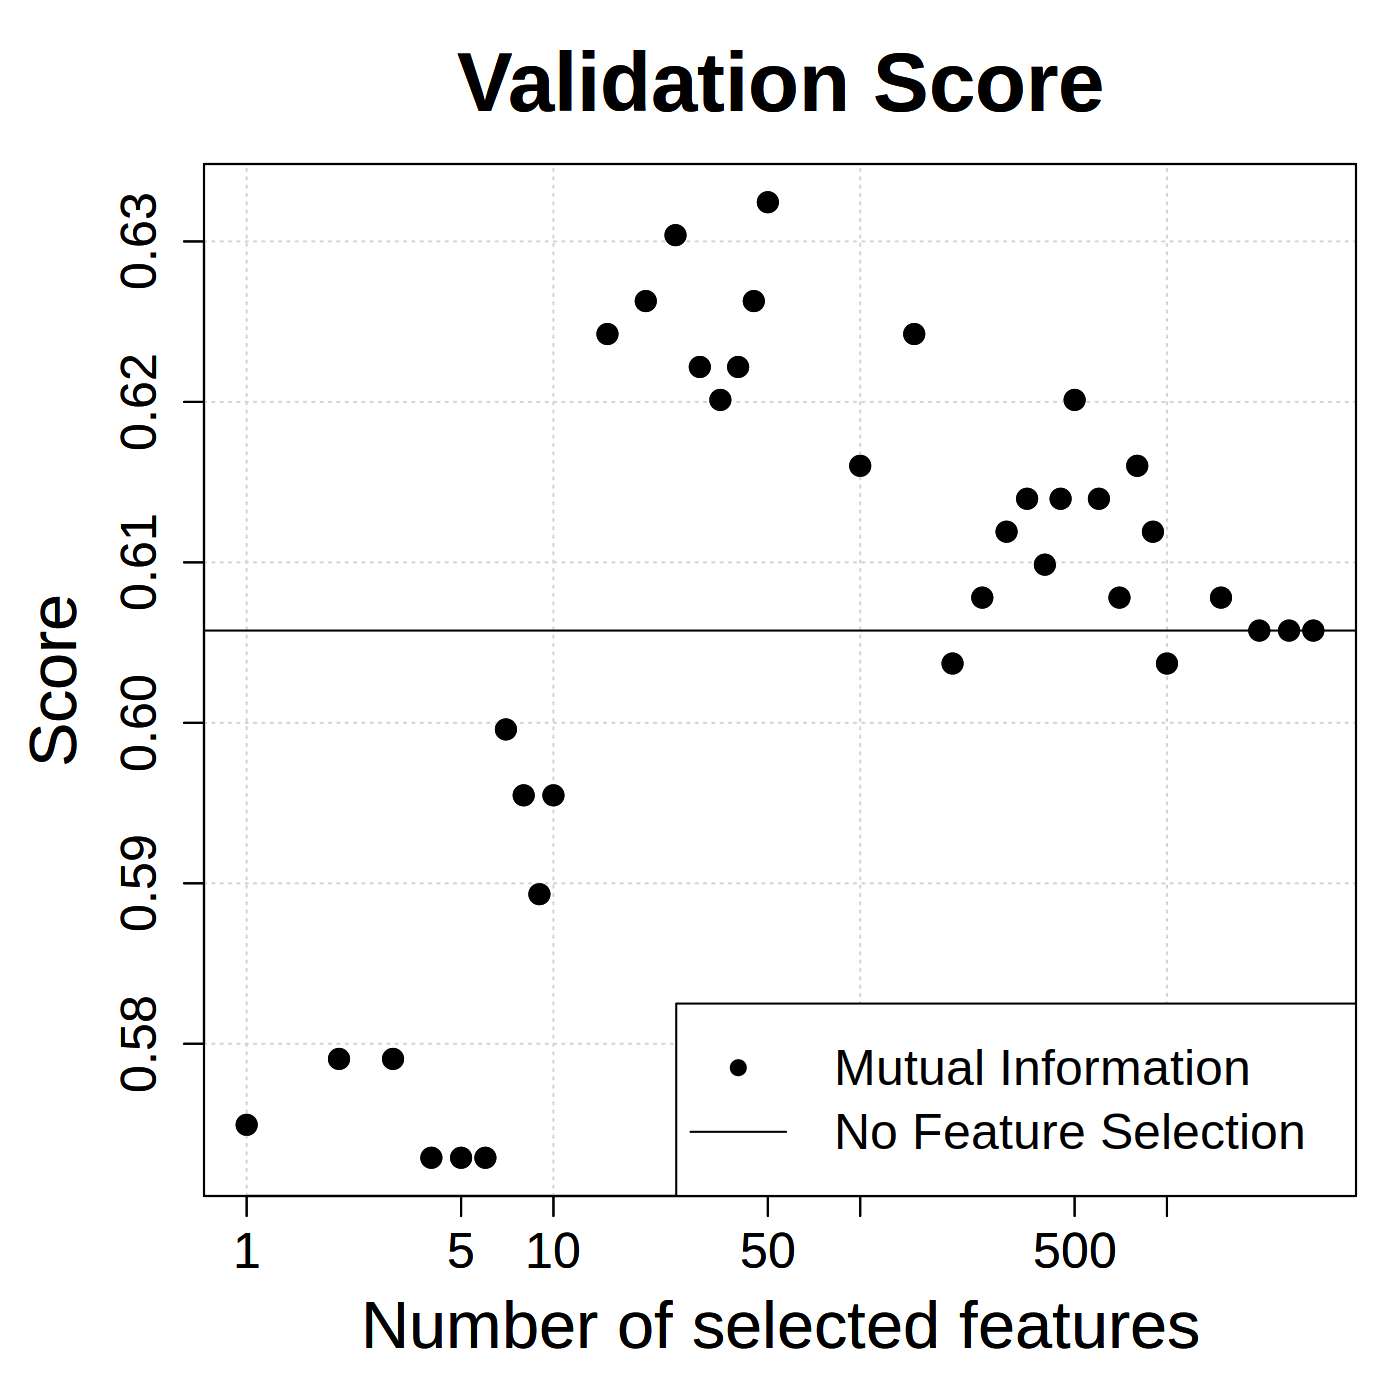

In [17]:
# png(file="var_binary_validation.png", width=800, height=800, pointsize=20)
# options(repr.plot.res=1000)
options(repr.plot.res=200)
par(mar=c(5,5,4,1)+.1)
plot(matbin[,1], matbin[,2], main="Validation Score", xlab="Number of selected features", ylab="Score", log="x", pch=20, cex.main=2.5, cex.lab=2, cex.axis=1.5, cex=2)
grid()
par(new=T, mar=c(5,5,4,1)+.1)
plot(matbin[,1], matbin[,2], main="Validation Score", xlab="Number of selected features", ylab="Score", log="x", pch=20, cex.main=2.5, cex.lab=2, cex.axis=1.5, cex=2)
abline(h=k0)
legend("bottomright", c("Mutual Information", "No Feature Selection"), lty=c(NA, 1), pch=c(20, NA), cex=1.5)
# dev.off()

## Load mat2

In [34]:
load("mat2.RData")

In [82]:
mat2

5,0.7513877,1046
10,0.7706390,886
15,0.7786701,797
20,0.7798512,605
25,0.7959135,467
30,0.8157553,338
35,0.8152829,324
40,0.8159915,295
45,0.8210700,269
50,0.8267391,260
100,0.8411480,163
